In [65]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
import warnings
warnings.filterwarnings("ignore")
import time

In [66]:
#Loading the data from csv files.
train=pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')

features=pd.read_csv('./data/features.csv')
stores = pd.read_csv('./data/stores.csv')

train.info()

In [67]:
#Check if all the dates present in the 'train.csv' is present in the 'features.csv'
if (train['Date'].unique() in features['Date'].unique()):
    print("Yes!")
    
def isSubset(arr1, arr2): 
    m = len(arr1)
    n = len(arr2)
    i = j = 0
    for i in range(n): 
        for j in range(m): 
            if(arr2[i] == arr1[j]): 
                break
        if (j == m): 
            return 0 
    return 1    

if(isSubset(features['Date'].unique(), train['Date'].unique())): 
    print("train['Date'] is subset of features['Date']") 
else: 
    print("train['Date'] is not a subset of features['Date']") 

train['Date'] is subset of features['Date']


In [68]:
#Check if all the dates present in the 'train.csv' is present in the 'features.csv'
if (test['Date'].unique() in features['Date'].unique()):
    print("Yes!")
    
def isSubset(arr1, arr2): 
    m = len(arr1)
    n = len(arr2)
    i = j = 0
    for i in range(n): 
        for j in range(m): 
            if(arr2[i] == arr1[j]): 
                break
        if (j == m): 
            return 0 
    return 1    

if(isSubset(features['Date'].unique(), test['Date'].unique())): 
    print("test['Date'] is subset of features['Date']") 
else: 
    print("test['Date'] is not a subset of features['Date']") 

test['Date'] is subset of features['Date']


In [69]:
# Fill the NaN values for MarkDown1-5 as zero.
features['MarkDown1'] = features['MarkDown1'].fillna(0)
features['MarkDown2'] = features['MarkDown2'].fillna(0)
features['MarkDown3'] = features['MarkDown3'].fillna(0)
features['MarkDown4'] = features['MarkDown4'].fillna(0)
features['MarkDown5'] = features['MarkDown5'].fillna(0)
#Fill the NaN values for CPI and Unemployment columns with their respective column mean at the Store level.
#This is because CPI and unemployment rates are usually calculated at City/geographic areas (regions and metropolitan areas)
#level.
features['CPI'] = features['CPI'].fillna(features.groupby('Store')['CPI'].transform('mean'))

In [70]:
#Merge the three input files into one data file
train_data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
test_data = test.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')

In [71]:
#Drop the additional Is_Holiday column
train_data = train_data.drop(['IsHoliday_y'],axis=1)
train_data = train_data.rename(columns={'IsHoliday_x':'IsHoliday'})

test_data = test_data.drop(['IsHoliday_y'],axis=1)
test_data = test_data.rename(columns={'IsHoliday_x':'IsHoliday'})

In [72]:
# Change the date coulmn to pd.to_datetime
train_data['Date'] = pd.to_datetime(train_data['Date'])

test_data['Date'] = pd.to_datetime(test_data['Date'])

In [73]:
test_base = test.copy()

In [74]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


# EDA



In [75]:
# def scatter_plots(dataset, column):
#     plt.figure()
#     plt.scatter(dataset[column], dataset['Weekly_Sales'])
#     plt.xlabel(column)
#     plt.ylabel('Weekly_Sales')
    
# scatter_plots(train_data, 'Store')    
# scatter_plots(train_data, 'Dept')    
# scatter_plots(train_data, 'Date')    
# scatter_plots(train_data, 'IsHoliday')    
# scatter_plots(train_data, 'Temperature')    
# scatter_plots(train_data, 'Fuel_Price')  
# scatter_plots(train_data, 'MarkDown1')
# scatter_plots(train_data, 'MarkDown2')
# scatter_plots(train_data, 'MarkDown3')
# scatter_plots(train_data, 'MarkDown4')
# scatter_plots(train_data, 'MarkDown5')
# scatter_plots(train_data, 'CPI')
# scatter_plots(train_data, 'Unemployment')
# scatter_plots(train_data, 'Type')
# scatter_plots(train_data, 'Size')

[]

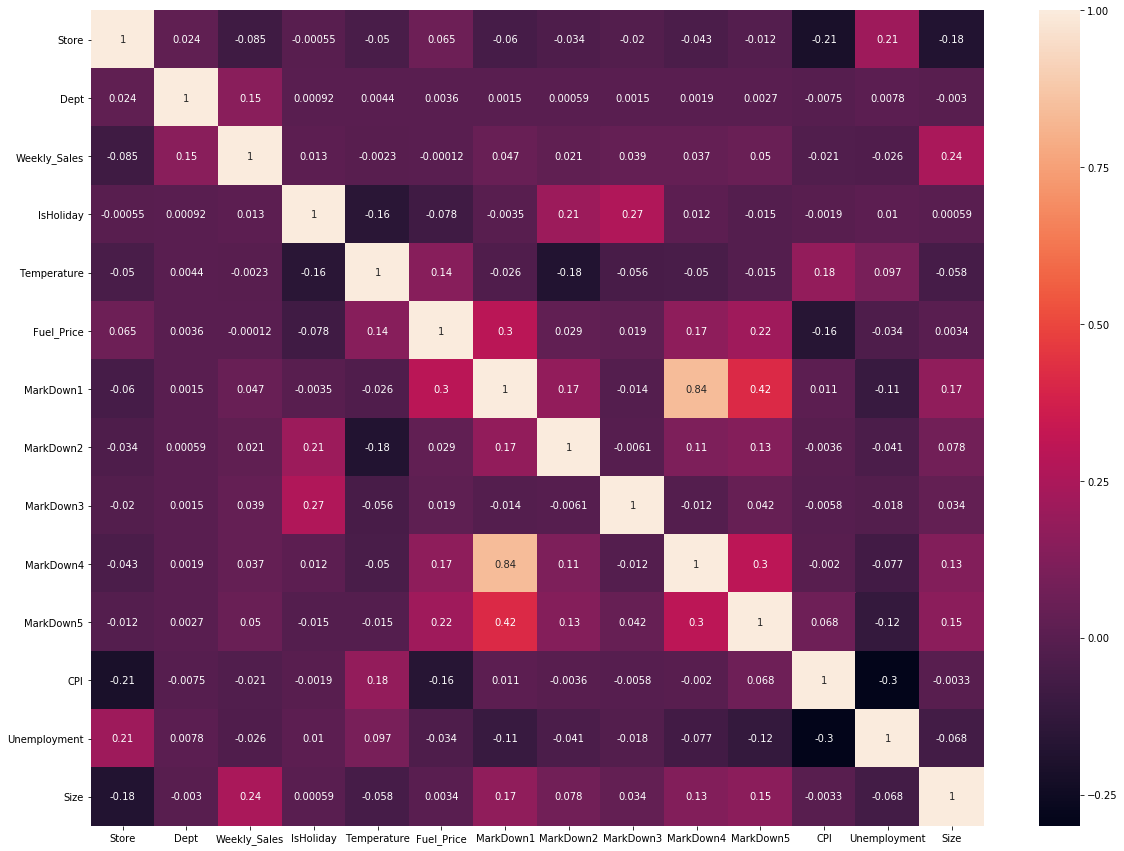

In [76]:
# Correlation matrix
corr = train_data.corr()
plt.figure(figsize=(20,15))
ax = sns.heatmap(corr, annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.plot()

# Prepare the data for Machine Learning algorithms.

In [77]:
# Lets delete Temperature, Fuel_Price and Unemployment. Also drop the 'Fuel_Price' columns because thats is integral part of CPI data

train_data = train_data.drop(['Temperature', 'Fuel_Price', 'Unemployment'],axis=1)

test_data = test_data.drop(['Temperature', 'Fuel_Price', 'Unemployment'],axis=1)

In [78]:
# Encode Categorical variable 'Type' using one hot/get_dummies
train_data = train_data.join(pd.get_dummies(train_data.Type,prefix="Type"))
train_data.update(train_data.drop("Type",axis=1,inplace=True))
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Size,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,0.0,0.0,0.0,0.0,0.0,211.096358,151315,1,0,0
1,1,2,2010-02-05,50605.27,False,0.0,0.0,0.0,0.0,0.0,211.096358,151315,1,0,0
2,1,3,2010-02-05,13740.12,False,0.0,0.0,0.0,0.0,0.0,211.096358,151315,1,0,0
3,1,4,2010-02-05,39954.04,False,0.0,0.0,0.0,0.0,0.0,211.096358,151315,1,0,0
4,1,5,2010-02-05,32229.38,False,0.0,0.0,0.0,0.0,0.0,211.096358,151315,1,0,0


In [79]:
test_data = test_data.join(pd.get_dummies(test_data.Type,prefix="Type"))
test_data.update(test_data.drop("Type",axis=1,inplace=True))
test_data.head()

,Store,Dept,Date,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Size,Type_A,Type_B,Type_C
0,1,1,2012-11-02,False,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,151315,1,0,0
1,1,2,2012-11-02,False,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,151315,1,0,0
2,1,3,2012-11-02,False,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,151315,1,0,0
3,1,4,2012-11-02,False,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,151315,1,0,0
4,1,5,2012-11-02,False,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,151315,1,0,0


In [80]:
# Convert the bool column 'IsHoliday' from TRUE = 5 and FALSE = 1, so to give higher weightage to IsHoliday=True.

train_data['IsHoliday'] = train_data['IsHoliday'].replace(True, 5).replace(False, 1)
test_data['IsHoliday'] = test_data['IsHoliday'].replace(True, 5).replace(False, 1)

In [81]:
train_data

,Store,Dept,Date,Weekly_Sales,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Size,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,1.0,0.00,0.00,0.0,0.00,0.00,211.096358,151315,1,0,0
1,1,2,2010-02-05,50605.27,1.0,0.00,0.00,0.0,0.00,0.00,211.096358,151315,1,0,0
2,1,3,2010-02-05,13740.12,1.0,0.00,0.00,0.0,0.00,0.00,211.096358,151315,1,0,0
3,1,4,2010-02-05,39954.04,1.0,0.00,0.00,0.0,0.00,0.00,211.096358,151315,1,0,0
4,1,5,2010-02-05,32229.38,1.0,0.00,0.00,0.0,0.00,0.00,211.096358,151315,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,1.0,4018.91,58.08,100.0,211.94,858.33,192.308899,118221,0,1,0
421566,45,94,2012-10-26,5203.31,1.0,4018.91,58.08,100.0,211.94,858.33,192.308899,118221,0,1,0
421567,45,95,2012-10-26,56017.47,1.0,4018.91,58.08,100.0,211.94,858.33,192.308899,118221,0,1,0
421568,45,97,2012-10-26,6817.48,1.0,4018.91,58.08,100.0,211.94,858.33,192.308899,118221,0,1,0


In [82]:
# Cyclical encoding for the dates
# As the data is Time-Series we sort them in ascending order so that the model can perform on the historical data.
train_data = train_data.sort_values(by='Date', ascending=True)

#Convert the Date columns to Week#, Month and Year. And since week# and month are cyclical features we will handle 
#them accordingly.
train_data['Month'] = train_data['Date'].dt.month
train_data['Year'] = train_data['Date'].dt.year
train_data['Week'] = train_data['Date'].dt.week
train_data['month_sin'] = np.sin((train_data.Month-1)*(2.*np.pi/12))
train_data['month_cos'] = np.cos((train_data.Month-1)*(2.*np.pi/12))
train_data['week_sin'] = np.sin((train_data.Week-1)*(2.*np.pi/52.1429))
train_data['week_cos'] = np.cos((train_data.Week-1)*(2.*np.pi/52.1429))
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Type_A,Type_B,Type_C,Month,Year,Week,month_sin,month_cos,week_sin,week_cos
0,1,1,2010-02-05,24924.50,1.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,2,2010,5,0.5,0.866025,0.46355,0.886071
330761,35,3,2010-02-05,14612.19,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,2,2010,5,0.5,0.866025,0.46355,0.886071
330762,35,4,2010-02-05,26323.15,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,2,2010,5,0.5,0.866025,0.46355,0.886071
330763,35,5,2010-02-05,36414.63,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,2,2010,5,0.5,0.866025,0.46355,0.886071
330764,35,6,2010-02-05,11437.81,1.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,2,2010,5,0.5,0.866025,0.46355,0.886071


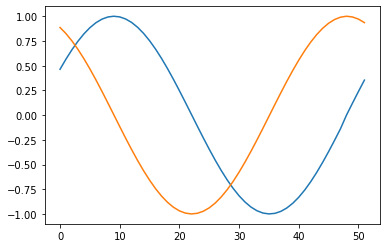

In [83]:
test1 = pd.DataFrame(train_data['week_sin'].unique())
test2 = pd.DataFrame(train_data['week_cos'].unique())
plt.plot(test1)
plt.plot(test2)
plt.show()

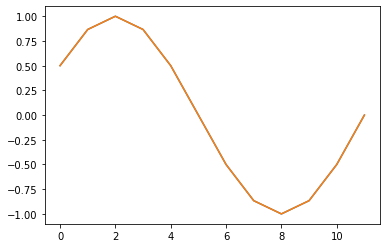

In [84]:
test1 = pd.DataFrame(train_data['month_sin'].unique())
test2 = pd.DataFrame(train_data['month_sin'].unique())
plt.plot(test1)
plt.plot(test2)
plt.show()

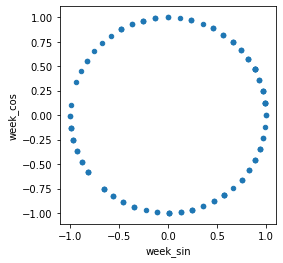

In [85]:
train_data.sample(144).plot.scatter('week_sin','week_cos').set_aspect('equal');

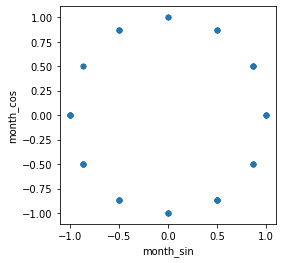

In [86]:
train_data.sample(144).plot.scatter('month_sin','month_cos').set_aspect('equal');

In [87]:
# Repeat the above step for test data

test_data = test_data.sort_values(by='Date', ascending=True)

test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['Month'] = test_data['Date'].dt.month
test_data['Year'] = test_data['Date'].dt.year
test_data['Week'] = test_data['Date'].dt.week
test_data['month_sin'] = np.sin((test_data.Month-1)*(2.*np.pi/12))
test_data['month_cos'] = np.cos((test_data.Month-1)*(2.*np.pi/12))
test_data['week_sin'] = np.sin((test_data.Week-1)*(2.*np.pi/52.1429))
test_data['week_cos'] = np.cos((test_data.Week-1)*(2.*np.pi/52.1429))
test_data.head()

,Store,Dept,Date,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Type_A,Type_B,Type_C,Month,Year,Week,month_sin,month_cos,week_sin,week_cos
0,1,1,2012-11-02,1.0,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,...,1,0,0,11,2012,44,-0.866025,0.5,-0.891983,0.452068
37648,15,74,2012-11-02,1.0,4565.57,5904.29,9.00,1437.77,1226.03,138.622710,...,0,1,0,11,2012,44,-0.866025,0.5,-0.891983,0.452068
37647,15,72,2012-11-02,1.0,4565.57,5904.29,9.00,1437.77,1226.03,138.622710,...,0,1,0,11,2012,44,-0.866025,0.5,-0.891983,0.452068
37646,15,71,2012-11-02,1.0,4565.57,5904.29,9.00,1437.77,1226.03,138.622710,...,0,1,0,11,2012,44,-0.866025,0.5,-0.891983,0.452068
37645,15,67,2012-11-02,1.0,4565.57,5904.29,9.00,1437.77,1226.03,138.622710,...,0,1,0,11,2012,44,-0.866025,0.5,-0.891983,0.452068


In [88]:
# Keep a copy for test_data for creating the submission file 
test_base = test_data.copy()

# Drop the date related columns that are not required anymore.

train_data = train_data.drop(['Date', 'Month', 'Year', 'Week'],axis=1)

test_data = test_data.drop(['Date', 'Month', 'Year', 'Week'],axis=1)

train_data.head()
# test_data.head()

,Store,Dept,Weekly_Sales,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Size,Type_A,Type_B,Type_C,month_sin,month_cos,week_sin,week_cos
0,1,1,24924.50,1.0,0.0,0.0,0.0,0.0,0.0,211.096358,151315,1,0,0,0.5,0.866025,0.46355,0.886071
330761,35,3,14612.19,1.0,0.0,0.0,0.0,0.0,0.0,135.352461,103681,0,1,0,0.5,0.866025,0.46355,0.886071
330762,35,4,26323.15,1.0,0.0,0.0,0.0,0.0,0.0,135.352461,103681,0,1,0,0.5,0.866025,0.46355,0.886071
330763,35,5,36414.63,1.0,0.0,0.0,0.0,0.0,0.0,135.352461,103681,0,1,0,0.5,0.866025,0.46355,0.886071
330764,35,6,11437.81,1.0,0.0,0.0,0.0,0.0,0.0,135.352461,103681,0,1,0,0.5,0.866025,0.46355,0.886071


# Feature Scaling

In [89]:
# from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# SScaler = StandardScaler()
# X_train = SScaler.fit_transform(X_train)
# X_test = SScaler.fit_transform(X_test)

# RScaler = RobustScaler()
# X_train = RScaler.fit_transform(X_train)
# X_test = RScaler.fit_transform(X_test)

# norm = Normalizer()
# X_train = norm.fit_transform(X_train)
# X_test = norm.fit_transform(X_test)

In [90]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

In [91]:
def decTreeRegressor():
    dt = DecisionTreeRegressor(random_state=0)
    return dt

def extraTreesRegressor():
    clf = ExtraTreesRegressor(n_estimators=100,max_features='auto', verbose=1, n_jobs=1)
    return clf

def randomForestRegressor():
    clf = RandomForestRegressor(n_estimators=100,max_features='log2', verbose=1)
    return clf

def svm():
    clf = SVR(kernel='rbf', gamma='auto')
    return clf

def nn():
    clf = MLPRegressor(hidden_layer_sizes=(10,),  activation='relu', verbose=3)
    return clf

def xgbRegressor():
    xgb_reg = XGBRegressor(nthread= 4, n_estimators= 500, max_depth= 6, learning_rate= 0.5)
    return xgb_reg

def predict_(m, test_x):
    return pd.Series(m.predict(test_x))

def model_():
#     return decTreeRegressor()
    return extraTreesRegressor()
#     return randomForestRegressor()  
#     return svm()
#     return nn()
#     return xgbRegressor()
  
def train_(train_x, train_y):
    m = model_()
    m.fit(train_x, train_y)
    return m

def train_and_predict(train_x, train_y, test_x):
    m = train_(train_x, train_y)
    return predict_(m, test_x), m

def calculate_error(test_y, predicted, weights):
    return mean_absolute_error(test_y, predicted, sample_weight=weights)

In [92]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
splited = []
# dataset2 = dataset.copy()
for name, group in train_data.groupby(["Store", "Dept"]):
    group = group.reset_index(drop=True)
    trains_x = []
    trains_y = []
    tests_x = []
    tests_y = []
    if group.shape[0] <= 5:
        f = np.array(range(5))
        np.random.shuffle(f)
        group['fold'] = f[:group.shape[0]]
        continue
    fold = 0
    for train_index, test_index in kf.split(group):
        group.loc[test_index, 'fold'] = fold
        fold += 1
    splited.append(group)

splited = pd.concat(splited).reset_index(drop=True)

In [93]:
start_time = time.time()

In [94]:
best_model = None
error_cv = 0
best_error = np.iinfo(np.int32).max

for fold in range(5):
    dataset_train = splited.loc[splited['fold'] != fold]
    dataset_test = splited.loc[splited['fold'] == fold]
    
    train_y = dataset_train['Weekly_Sales']
    train_x = dataset_train.drop(columns=['Weekly_Sales', 'fold'])
    test_y = dataset_test['Weekly_Sales']
    test_x = dataset_test.drop(columns=['Weekly_Sales', 'fold'])

    predicted, model = train_and_predict(train_x, train_y, test_x)

    weights = test_x['IsHoliday']
    error = calculate_error(test_y, predicted, weights)
    error_cv += error
    print("fold :",fold, "error :", error)
    if error < best_error:  
        best_error = error
        best_model = model
        print('Find best model:',best_model, "best_error :",best_error)
error_cv /= 5

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


fold : 0 error : 1770.5135718967906
Find best model: ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                    oob_score=False, random_state=None, verbose=1,
                    warm_start=False) best_error : 1770.5135718967906


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


fold : 1 error : 2848.206065385696


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished


fold : 2 error : 1429.811406183554
Find best model: ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                    oob_score=False, random_state=None, verbose=1,
                    warm_start=False) best_error : 1429.811406183554


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


fold : 3 error : 2006.317149230769


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished


fold : 4 error : 1587.7341902706078


In [95]:
error_cv

1928.5164765934835

In [96]:
best_error

1429.811406183554

In [97]:
predicted_test = best_model.predict(test_data)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.5s finished


In [99]:
#print("Execution time(secs) :" % (time.time() - start_time))

In [ ]:
# test_data.head()

In [100]:
column_date = test_base['Date']
test_data['Weekly_Sales'] = predicted_test
test_data['Date'] = column_date
test_data['id'] = test_data['Store'].astype(str) + '_' +  test_data['Dept'].astype(str) + '_' +  test_data['Date'].astype(str)
test_data = test_data[['id', 'Weekly_Sales']]
test_data = test_data.rename(columns={'id': 'Id'})

In [101]:
test_data.to_csv('output.csv', index=False)